In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [4]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [5]:
# Init model
eta = 1
scaler = 1
model = neuralGrU(B=64, eta_c=eta, eta_d=eta, alpha=1e2).to(device)

#### Input Data

In [11]:
# # Price vectors sampled from Normal Distribution(mu=0, sigma=1)
# prices = np.abs(np.random.normal(loc=0, scale=1, size=(5, 24))) * scaler

> Hyperparameters: lr = 0.125, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [6]:
# Price vectors sampled from Uniform Distribution [0, 1)
prices = np.random.random(size=(5, 24)) * scaler

> Hyperparameters: lr = 0.1, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [66]:
# # Price vectors from Auction Data
# prices = getPriceVectors(300) * scaler

> Hyperparameters: lr = 1, gamma = 0.92, B = 1, scaler = 1 Curriculum Learning & ExponentialLR Scheduler

In [7]:
# Discharge & PV demand constraints 
Caps = np.ones((24, 3)) * 1e2
Caps[:, 0] = 4
Caps[:, 1] = 4

In [8]:
# Total demand tensor (Unit)
d_t = torch.ones(24, requires_grad=False, device=device) * 5
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_t = torch.tensor(Caps, requires_grad=False, device=device)

grid_shift = 0

# Price tensors
pi_g = torch.tensor(prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [9]:
# Hyperparameter(s)
learning_rate = 0.008
epochs = 500

history = []
best_loss = 0

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e3:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:02<00:00, 178.48it/s]


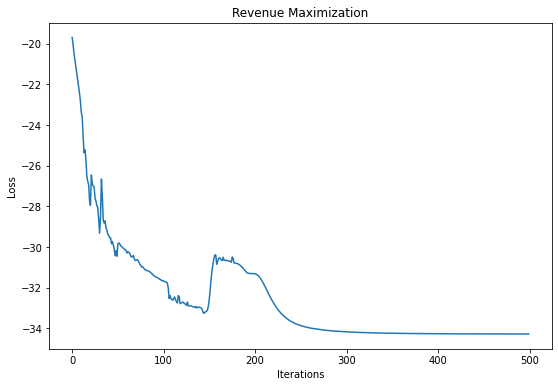

In [10]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [11]:
best_loss, loss

(-34.27089607126355, -34.27089607126355)

In [19]:
pi_optimal

[tensor([0.6242, 0.2558, 0.8508, 0.7599, 0.7192, 0.6458, 0.9673, 0.5147, 0.4455,
         0.7145, 0.8938, 0.9312, 0.9151, 0.5083, 0.7911, 0.8321, 0.2515, 0.6069,
         0.0772, 0.3381, 0.8359, 0.6012, 0.1355, 0.6807], dtype=torch.float64),
 tensor([0.0041, 0.6988, 0.7275, 0.6300, 0.4862, 0.8945, 0.3486, 0.8875, 0.2642,
         0.4482, 0.4993, 0.2506, 0.0125, 0.1402, 0.8940, 0.6834, 0.4148, 0.1034,
         0.5757, 0.6147, 0.0824, 0.6887, 0.1701, 0.0107], dtype=torch.float64),
 tensor([0.9176, 0.8045, 0.2396, 0.2123, 0.5322, 0.2246, 0.1899, 0.4367, 0.6179,
         0.3408, 0.4457, 0.6332, 0.7776, 0.5264, 0.2485, 0.4979, 0.7036, 0.2820,
         0.7301, 0.1286, 0.2960, 0.9904, 0.4909, 0.3276], dtype=torch.float64),
 tensor([0.8949, 0.7921, 0.3346, 0.4360, 0.4825, 0.4464, 0.5399, 0.7754, 0.9172,
         0.7658, 0.0922, 0.8709, 0.3728, 0.4026, 0.9938, 0.6781, 0.0140, 0.2406,
         0.9765, 0.2580, 0.7128, 0.0146, 0.8340, 0.5494], dtype=torch.float64)]

In [16]:
d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_t)

In [17]:
torch.round(pi_g - pi_p, decimals=2)

tensor([-0.3900, -0.2000, -0.1300,  0.1900,  0.0200,  0.2500, -0.6700, -0.2200,
        -0.4200,  0.0100, -0.4600, -0.3000,  0.0000,  0.0100,  0.0100,  0.0100,
         0.0000,  0.2800, -0.0500,  0.0000,  0.0000, -0.1200,  0.0000, -0.4000],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

In [18]:
torch.round(d_star, decimals=2)

tensor([[5.0000, 5.0000, 5.0000, 1.0000, 1.0000, 1.0000, 5.0000, 5.0000, 5.0000,
         1.0000, 5.0000, 5.0000, 0.0800, 1.0000, 1.0000, 1.0000, 0.0500, 1.0000,
         5.0000, 0.0500, 0.3700, 5.0000, 0.0500, 5.0000],
        [0.0000, 0.0000, 0.0000, 4.0000, 4.0000, 4.0000, 0.0000, 0.0000, 0.0000,
         4.0000, 0.0000, 0.0000, 4.9200, 4.0000, 4.0000, 4.0000, 4.9500, 4.0000,
         0.0000, 4.9500, 4.6300, 0.0000, 4.9500, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0

#### Demand breakup on optimised prices

In [294]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [295]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [296]:
evaluate(d_break, d_break_nn)[0]

[0.00016906086314523222, 0.00016906086314524837, 0.0, 0.0, 0.0]

In [297]:
d_break

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Revenue Maximisation with Gradient Clipping

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [298]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [810]:
# Init model
eta = 1
B = 256
scaler = 1

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [823]:
# prices = getPriceVectors(100) * scaler
scaled_prices = prices * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(scaled_prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(scaled_prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(scaled_prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(scaled_prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(scaled_prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [824]:
# Hyperparameter(s)
learning_rate = 0.025
epochs = 500

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.982)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 162.10it/s]


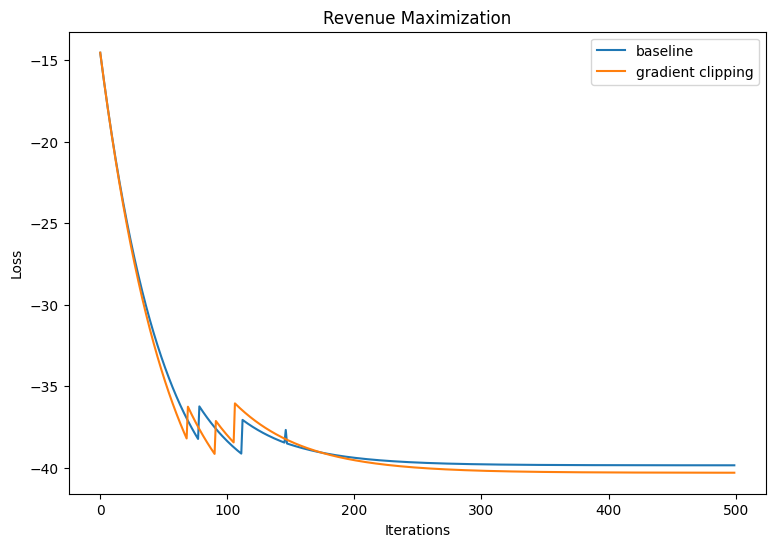

In [825]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [558]:
(pi_g > pi_p).all()

tensor(True)

In [826]:
(pi_g - pi_p) / scaler

tensor([ 0.3661,  1.8690,  0.5150, -0.0408, -0.0312,  0.8866,  0.1038,  0.3904,
         1.3893,  0.8990,  0.1514,  1.9923,  0.6137,  0.7580,  0.5715,  0.3316,
         0.6517, -0.0619,  0.7804,  0.6153,  0.7038,  1.8420,  1.2148,  0.4223],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [827]:
np.round(d_star.detach().numpy())

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-agent Revenue Maximization

In [71]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [72]:
prices = getPriceVectors(300)

# Random total demand tensor
# d_t = torch.rand(24, requires_grad=False) * 10
d_t = torch.ones(24, requires_grad=False, device=device) * 10

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

# EI tensor
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = torch.tensor(ep, requires_grad=False, device=device) * 1e3

In [73]:
n_agents = 5
gamma = [1, 2, 3, 4, 5]

models = {i: neuralGrU(B=1).to(device) for i in range(n_agents)}
d_star_n = torch.tensor(np.ndarray(shape=(n_agents, 5, 24)), device=device)

# Hyperparameter(s)
learning_rate = 1
epochs = 100

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

for t in trange(epochs):
    for agent in range(n_agents):
        # Update pi_g with EI
        pi_g_ei = pi_g + gamma[agent] * ep_t
        d_star_n[agent] = models[agent](pi_g_ei, pi_p, pi_s, pi_c, pi_d, d_t)

    d_star_total = torch.sum(d_star_n, dim=0)    
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star_total)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    # Curriculum Learning
    for agent in range(n_agents):
        if t % 10 == 0 and models[agent].B < 1e4:
            models[agent].B *= 2

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


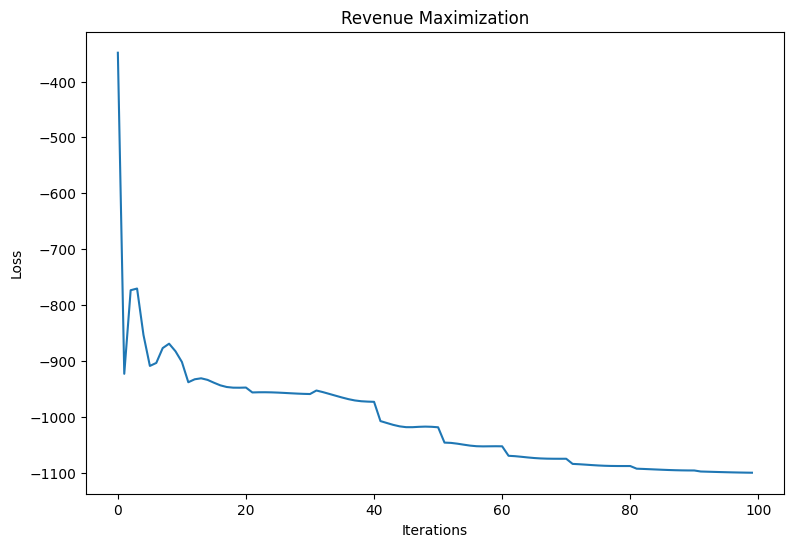

In [74]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [75]:
pi_p

tensor([1.6474, 1.5766, 1.5384, 1.5359, 1.5400, 1.5406, 1.5394, 1.5598, 1.6159,
        1.1597, 1.5416, 1.4614, 1.4143, 1.3898, 1.3928, 1.3602, 1.3278, 1.3540,
        1.4384, 1.2519, 1.3082, 1.3037, 1.2509, 1.5566], dtype=torch.float64,
       requires_grad=True)

In [76]:
ep_t * 3 + pi_g

tensor([1.6544, 1.5847, 1.5447, 1.5421, 1.5464, 1.5469, 1.5457, 1.5680, 1.6242,
        1.5792, 1.5498, 1.4692, 1.4211, 1.3963, 1.3992, 1.3673, 1.3353, 1.3610,
        1.4450, 1.6363, 1.7098, 1.7127, 1.6536, 1.5640], dtype=torch.float64)

In [77]:
pi_g

tensor([0.3138, 0.2408, 0.1935, 0.1749, 0.1655, 0.1669, 0.1912, 0.2558, 0.3411,
        0.3460, 0.3266, 0.3091, 0.3031, 0.2994, 0.3076, 0.2944, 0.3057, 0.3297,
        0.3864, 0.4992, 0.5209, 0.5017, 0.4622, 0.3914], dtype=torch.float64)

In [78]:
d_star_n[:, 1]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, 1.2433e-178,
          0.0000e+00,  0.0000e+00,  0.0000e+00, 6.4229e-322, 2.0800e-320,
         1.6920e-314, 1.6760e-301, 3.0140e-302, 1.6847e-310, 9.1651e-166,
         1.7630e-173, 9.5661e-177, 9.4393e-174,  0.0000e+00],
        [3.1953e-195, 3.1862e-195, 4.1698e-197, 1.7966e-199, 1.8972e-201,
         2.4139e-201, 1.3619e-197, 1.7671e-190, 4.4417e-186,  9.9988e+00,
         2.7705e-177, 4.1508e-168, 2.7793e-162, 2.7191e-159, 1.3722e-158,
         1.8738e-155, 7.0290e-149, 2.2892e-149, 1.3968e-153,  9.9698e+00,
          9.9679e+00,  9.9681e+00,  9.9741e+00, 4.1421e-170],
        [ 9.9942e+00,  9.9981e+00,  9.9883e+00,  9.9881e+00,  9.9895e+00,
          9.9891e+00,  9.9885e+00,  9.9982e+00,  9.9986e+00,  1.0000e+01,
          9.9983e+00,  9.9974e+00,  9.9934e+00,  9.9910e+00,  9.9890e+00,
          9.9952e+00,  9.9966e+00,  9.9943e+00,  9.9914e+00,  

> PV demand of all 5 users